In [19]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [50]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [52]:
# Path to your single dataset folder (should have subfolders for each class)
data_dir = '/teamspace/studios/this_studio/new_papaya_Anis/new_papaya'  # e.g., 'vegetable_dataset/'

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # DenseNet121 default input size
NUM_CLASSES = 6
EPOCHS = 15
VAL_SPLIT = 0.2  # 20% for validation
TEST_SPLIT = 0.1  # 10% for testing

In [54]:
# Step 2: Load and preprocess dataset with progress bar
def load_dataset(data_dir):
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found!")
            continue

        print(f"Loading {class_name} images...")
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure RGB format
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0
                    if img_array.shape == (*IMAGE_SIZE, 3):
                        images.append(img_array)
                        labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [55]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
import numpy as np
import os

# 🏷️ Get class names
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# 🖼️ Load file paths and labels
file_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        file_paths.append(img_path)
        labels.append(class_idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# 🧼 Load and preprocess images
X_images = []
for img_path in file_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    X_images.append(img.numpy())

X_images = np.array(X_images)
y = labels

# 🔀 Split data: 15% test first
X_temp, X_test, y_temp, y_test = train_test_split(
    X_images, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# 🔀 Now split X_temp into 82.35% train and 17.65% val to make them 70% and 15% of original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765,  # 15% of original = 15/85 ≈ 0.1765
    random_state=42, 
    stratify=y_temp
)

print(f"\nOriginal counts: {Counter(y)}")
print(f"Train: {len(X_train)} (before SMOTE), Val: {len(X_val)}, Test: {len(X_test)}")

# 🔁 Apply SMOTE
print("\nApplying SMOTE to training data...")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_smote_flat, y_train_smote = smote.fit_resample(X_train_flat, y_train)
X_train_smote = X_train_smote_flat.reshape(-1, *X_train.shape[1:])

print(f"Before SMOTE: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print("Class distribution after SMOTE:", Counter(y_train_smote))

# 📦 Create TF datasets
def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, depth=NUM_CLASSES)))

train_ds = create_dataset(X_train_smote, y_train_smote).shuffle(1000).batch(BATCH_SIZE)
val_ds = create_dataset(X_val, y_val).batch(BATCH_SIZE)
test_ds = create_dataset(X_test, y_test).batch(BATCH_SIZE)

print("\n✅ Dataset sizes:")
print(f"Training samples: {len(X_train_smote)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Classes: ['Bacterial_Blight', 'Carica_Insect_Hole', 'Curled_Yellow_Spot', 'Yellow_Necrotic_Spots_Holes', 'healthy_leaf', 'pathogen_symptoms']



Original counts: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000})
Train: 4199 (before SMOTE), Val: 901, Test: 900

Applying SMOTE to training data...
Before SMOTE: 4199 samples
After SMOTE: 4200 samples
Class distribution after SMOTE: Counter({2: 700, 0: 700, 1: 700, 3: 700, 5: 700, 4: 700})

✅ Dataset sizes:
Training samples: 4200
Validation samples: 901
Test samples: 900


In [57]:
from tensorflow.keras.applications import ConvNeXtTiny  # ✅ Correct import
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 🧩 Model settings
input_shape = (224, 224, 3)
NUM_CLASSES = 6  # Adjust as per your dataset

# ⚙️ Load DenseNet169 base model with ImageNet weights (excluding top)
base_model = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = True  # Fine-tune whole model

# 🔨 Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 🧠 Final model
model = Model(inputs=base_model.input, outputs=predictions)

# 🧪 Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 📋 Model summary
model.summary()


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 56, 56,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │      4,800 │ add_12[0][0]      │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 56, 56,    │         96 │ convnext_tiny_st

 Total params: 28,216,934 (107.64 MB)

 Trainable params: 28,216,934 (107.64 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
!pip install visualkeras

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


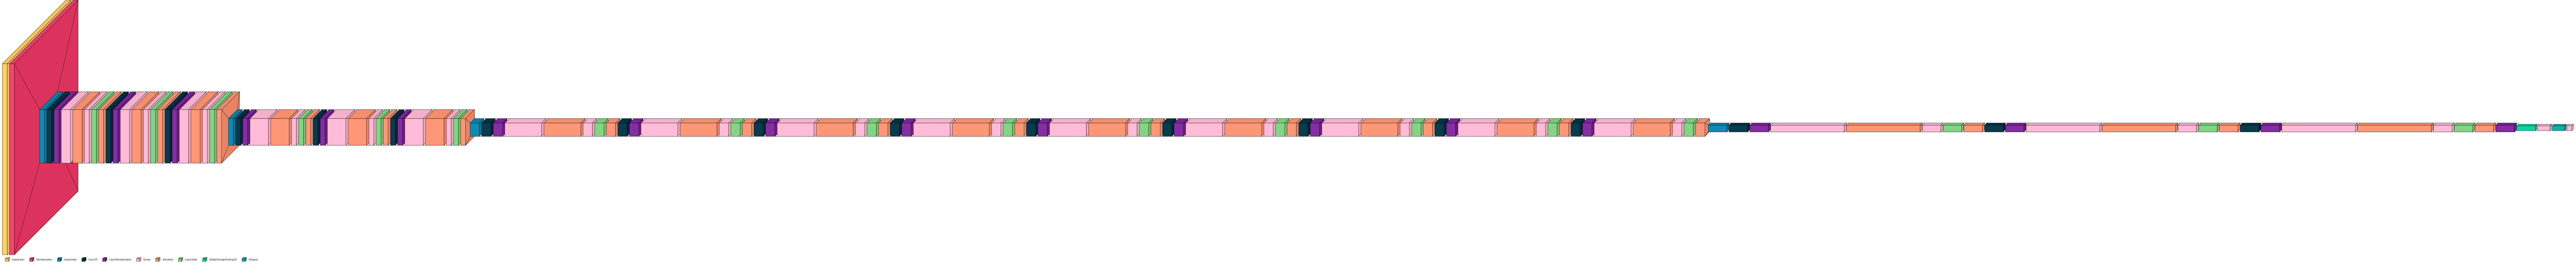

In [59]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=800)

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ✅ Define model name manually
model_name = "ConvNeXtTiny"

# ✅ Callbacks (using correct model name)
checkpoint = ModelCheckpoint(
    f"{model_name}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4
)

# ✅ Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/15


2025-06-18 18:03:33.958140: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 580 bytes spill stores, 580 bytes spill loads

2025-06-18 18:03:34.022325: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 444 bytes spill stores, 412 bytes spill loads

2025-06-18 18:03:34.051431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 672 bytes spill stores, 540 bytes spill loads

2025-06-18 18:03:34.160258: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 484 bytes spill stores, 452 bytes spill loads

2025-06-18 18:03:34.263826: I external/local_xla/xla

2025-06-18 18:03:59.592448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 304 bytes spill stores, 304 bytes spill loads

2025-06-18 18:04:00.225852: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 604 bytes spill stores, 604 bytes spill loads

2025-06-18 18:04:00.288560: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 1436 bytes spill stores, 1404 bytes spill loads

2025-06-18 18:04:00.375064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 776 bytes spill stores, 776 bytes spill loads

2025-06-18 18:04:00.466870: I external

131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4296 - loss: 1.4234 - precision_4: 0.6303 - recall_4: 0.2202

2025-06-18 18:05:30.995605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 188 bytes spill stores, 188 bytes spill loads

2025-06-18 18:05:31.073296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 444 bytes spill stores, 412 bytes spill loads

2025-06-18 18:05:31.151235: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 484 bytes spill stores, 452 bytes spill loads

2025-06-18 18:05:31.196940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 844 bytes spill stores, 844 bytes spill loads

2025-06-18 18:05:31.783247: I external/local_xla/xla

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.4310 - loss: 1.4200 - precision_4: 0.6318 - recall_4: 0.2220

2025-06-18 18:06:33.116363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 484 bytes spill stores, 452 bytes spill loads

2025-06-18 18:06:33.146043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 188 bytes spill stores, 188 bytes spill loads

2025-06-18 18:06:33.268719: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 844 bytes spill stores, 844 bytes spill loads

2025-06-18 18:06:33.316649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 1760 bytes spill stores, 1504 bytes spill loads

2025-06-18 18:06:33.624319: I external/local_xla/x

132/132 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.4325 - loss: 1.4166 - precision_4: 0.6332 - recall_4: 0.2238 - val_accuracy: 0.8424 - val_loss: 0.4107 - val_precision_4: 0.8818 - val_recall_4: 0.7869 - learning_rate: 1.0000e-04
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8762 - loss: 0.3350 - precision_4: 0.9036 - recall_4: 0.8407

132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 473ms/step - accuracy: 0.8765 - loss: 0.3343 - precision_4: 0.9038 - recall_4: 0.8411 - val_accuracy: 0.9423 - val_loss: 0.1679 - val_precision_4: 0.9461 - val_recall_4: 0.9345 - learning_rate: 1.0000e-04
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9816 - loss: 0.0655 - precision_4: 0.9868 - recall_4: 0.9804

132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 472ms/step - accuracy: 0.9816 - loss: 0.0654 - precision_4: 0.9868 - recall_4: 0.9805 - val_accuracy: 0.9822 - val_loss: 0.0607 - val_precision_4: 0.9844 - val_recall_4: 0.9778 - learning_rate: 1.0000e-04
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 0.9923 - loss: 0.0302 - precision_4: 0.9929 - recall_4: 0.9923 - val_accuracy: 0.9656 - val_loss: 0.0886 - val_precision_4: 0.9677 - val_recall_4: 0.9656 - learning_rate: 1.0000e-04
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9956 - loss: 0.0161 - precision_4: 0.9961 - recall_4: 0.9952

132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 470ms/step - accuracy: 0.9956 - loss: 0.0161 - precision_4: 0.9961 - recall_4: 0.9952 - val_accuracy: 0.9878 - val_loss: 0.0408 - val_precision_4: 0.9900 - val_recall_4: 0.9867 - learning_rate: 1.0000e-04
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9993 - loss: 0.0051 - precision_4: 0.9993 - recall_4: 0.9993

132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 470ms/step - accuracy: 0.9993 - loss: 0.0051 - precision_4: 0.9993 - recall_4: 0.9993 - val_accuracy: 0.9911 - val_loss: 0.0308 - val_precision_4: 0.9922 - val_recall_4: 0.9911 - learning_rate: 1.0000e-04
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 1.0000 - loss: 0.0011 - precision_4: 1.0000 - recall_4: 1.0000

132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 470ms/step - accuracy: 1.0000 - loss: 0.0011 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0225 - val_precision_4: 0.9944 - val_recall_4: 0.9933 - learning_rate: 1.0000e-04
Epoch 8/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 1.0000 - loss: 3.8166e-04 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0233 - val_precision_4: 0.9944 - val_recall_4: 0.9933 - learning_rate: 1.0000e-04
Epoch 9/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 1.0000 - loss: 2.5568e-04 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9922 - val_loss: 0.0250 - val_precision_4: 0.9933 - val_recall_4: 0.9911 - learning_rate: 1.0000e-04
Epoch 10/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 1.0000 - loss: 2.1425e-04 - precision_4: 1.0000 - recall_4: 1.0000

132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 469ms/step - accuracy: 1.0000 - loss: 2.1424e-04 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9945 - val_loss: 0.0241 - val_precision_4: 0.9944 - val_recall_4: 0.9933 - learning_rate: 1.0000e-04
Epoch 11/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 1.0000 - loss: 1.5991e-04 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0238 - val_precision_4: 0.9944 - val_recall_4: 0.9933 - learning_rate: 1.0000e-04
Epoch 12/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 1.0000 - loss: 1.4320e-04 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9945 - val_loss: 0.0231 - val_precision_4: 0.9944 - val_recall_4: 0.9933 - learning_rate: 1.0000e-04


In [61]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

2025-06-18 18:18:26.799587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 844 bytes spill stores, 844 bytes spill loads

2025-06-18 18:18:26.934371: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 580 bytes spill stores, 580 bytes spill loads

2025-06-18 18:18:26.989391: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 672 bytes spill stores, 540 bytes spill loads

2025-06-18 18:18:27.106886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 444 bytes spill stores, 412 bytes spill loads

2025-06-18 18:18:27.496122: I external/local_xla/xla

29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 917ms/step
Classification Report:
                             precision    recall  f1-score   support

           Bacterial_Blight       1.00      1.00      1.00       150
         Carica_Insect_Hole       0.97      0.97      0.97       150
         Curled_Yellow_Spot       0.98      0.97      0.98       150
Yellow_Necrotic_Spots_Holes       1.00      1.00      1.00       150
               healthy_leaf       0.99      1.00      0.99       150
          pathogen_symptoms       0.96      0.95      0.96       150

                   accuracy                           0.98       900
                  macro avg       0.98      0.98      0.98       900
               weighted avg       0.98      0.98      0.98       900

Confusion matrix, without normalization


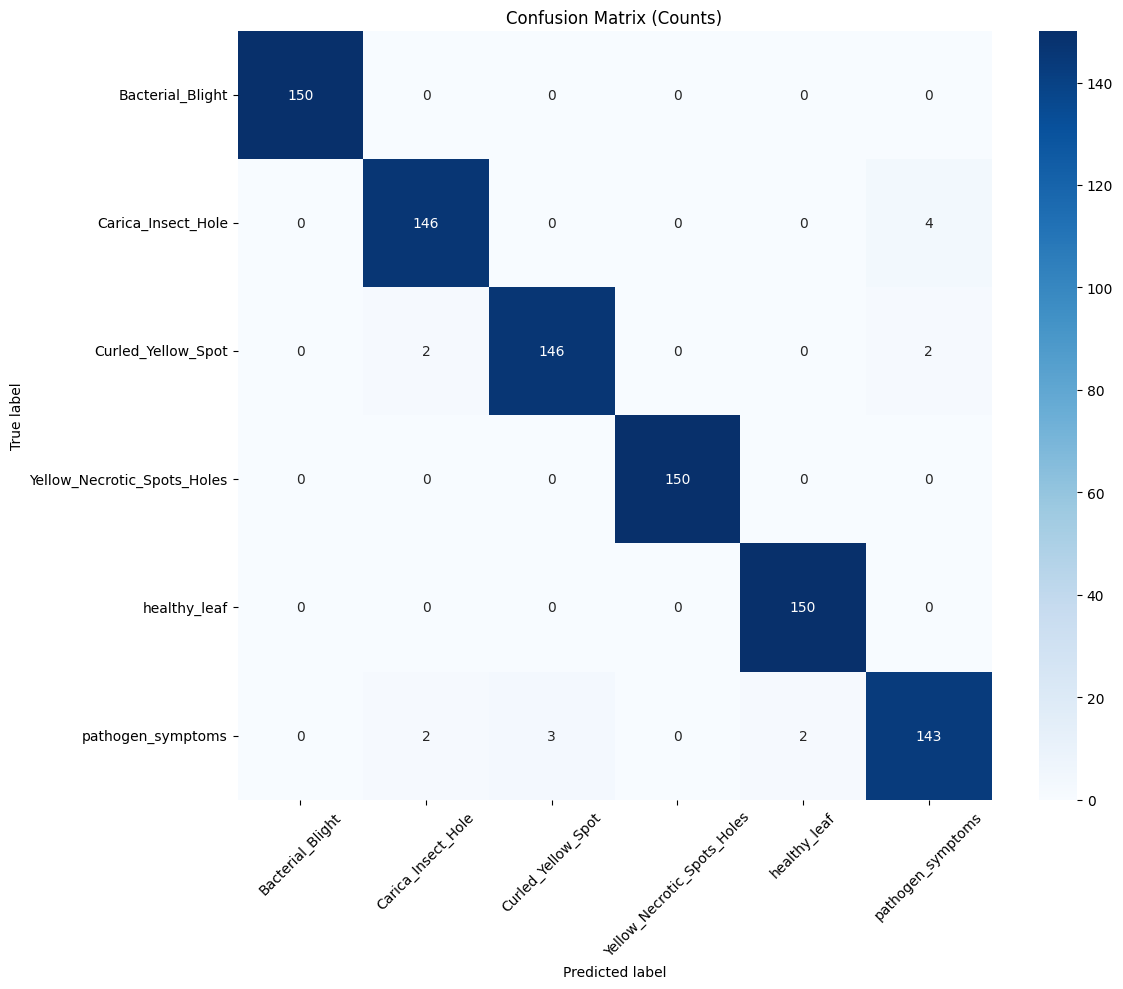

Normalized confusion matrix


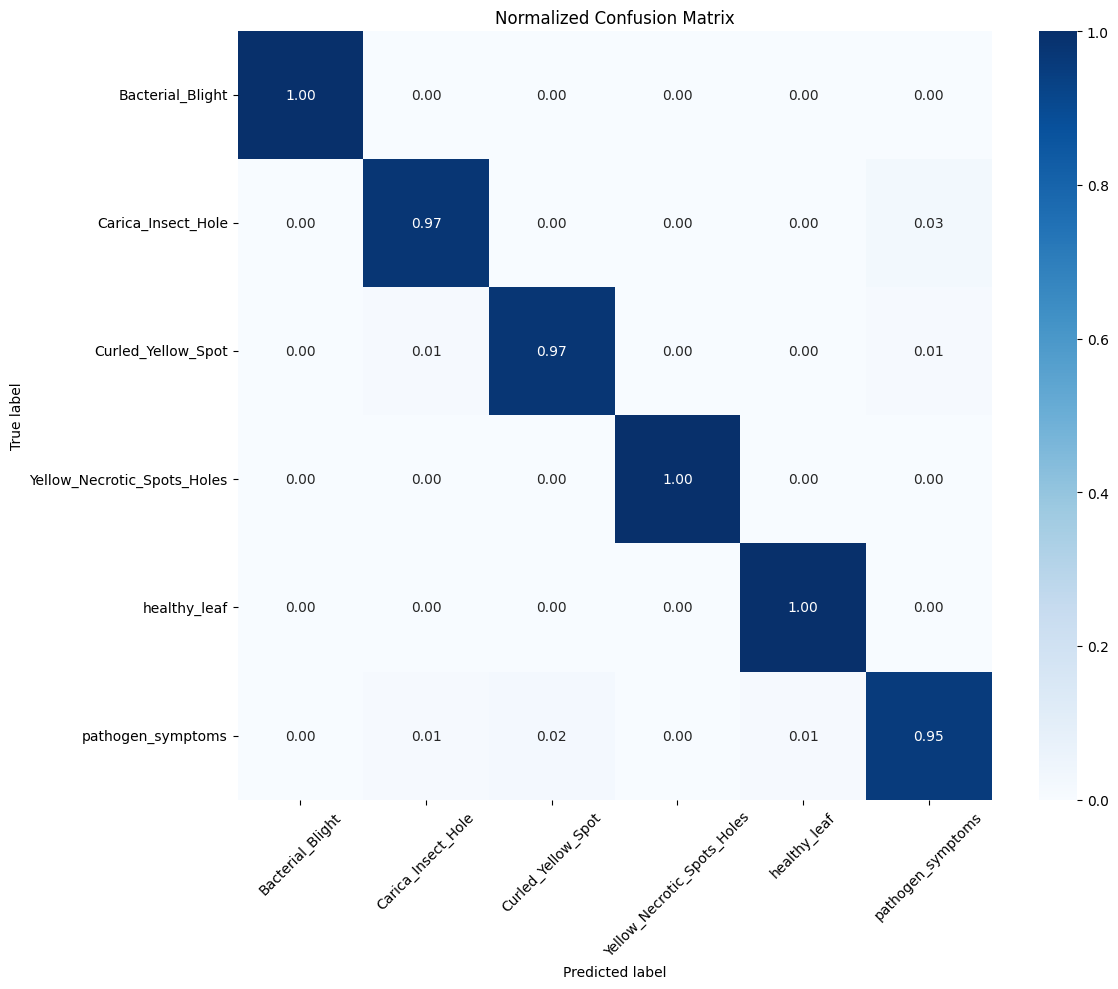

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion Matrix (Counts)')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix')

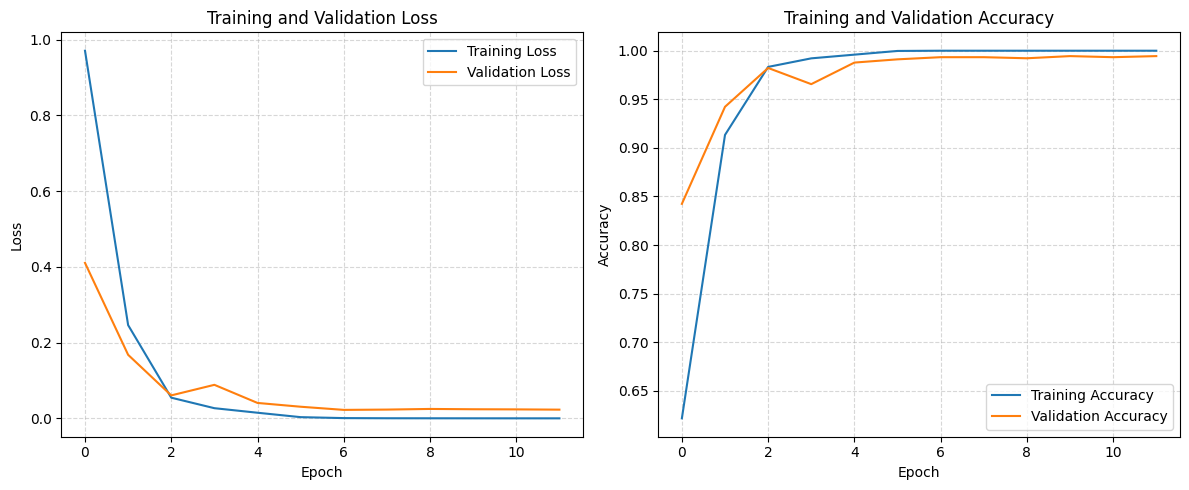


Best Validation Loss: 0.0225 at epoch 7
Corresponding Training Loss: 0.0008
Validation Accuracy at Best Epoch: 0.9933


In [63]:
import matplotlib.pyplot as plt

# Get training history from model.fit()
history = model.history.history

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# 1. Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Print best validation accuracy
best_val_epoch = np.argmin(history['val_loss'])
print(f"\nBest Validation Loss: {min(history['val_loss']):.4f} at epoch {best_val_epoch + 1}")
print(f"Corresponding Training Loss: {history['loss'][best_val_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {history['val_accuracy'][best_val_epoch]:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


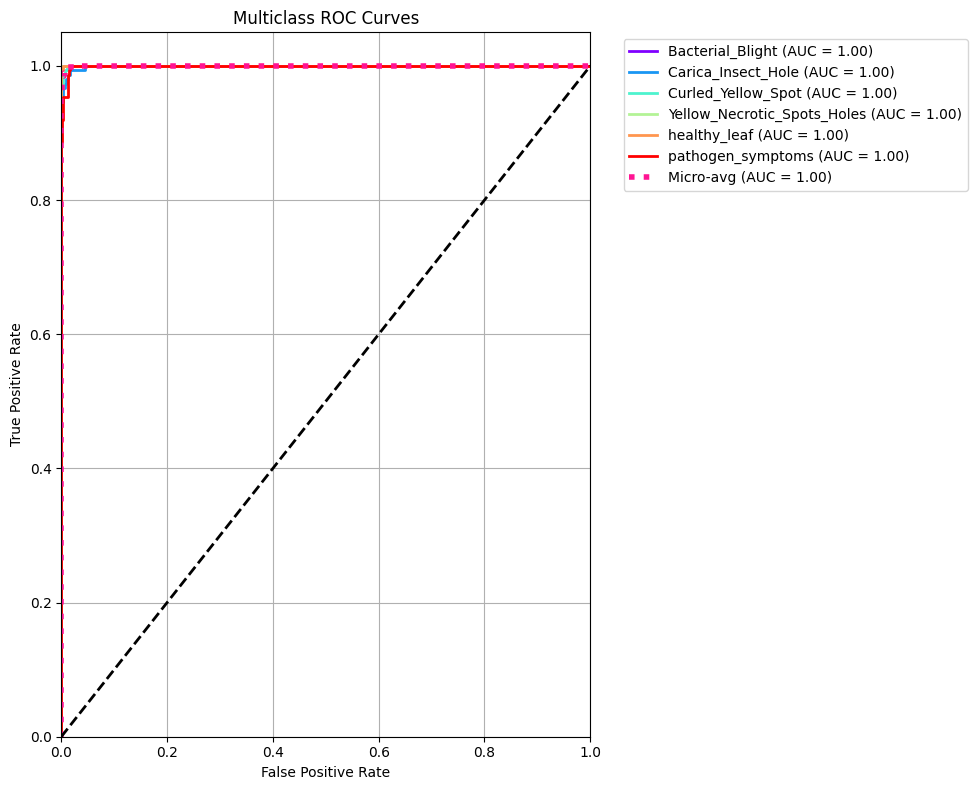


AUC Scores:
Bacterial_Blight: 1.0000
Carica_Insect_Hole: 0.9993
Curled_Yellow_Spot: 0.9998
Yellow_Necrotic_Spots_Holes: 1.0000
healthy_leaf: 1.0000
pathogen_symptoms: 0.9992

Micro-average AUC: 0.9998


In [64]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions and true labels from test set
y_pred = model.predict(test_ds)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot to labels

# 2. Binarize the true labels for multiclass ROC
y_true_bin = label_binarize(y_true_labels, classes=np.arange(NUM_CLASSES))

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute micro-average ROC curve and area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Generate enough colors for all classes
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES)))

# 6. Plot ROC curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

# Plot micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-avg (AUC = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print AUC scores
print("\nAUC Scores:")
for i in range(NUM_CLASSES):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


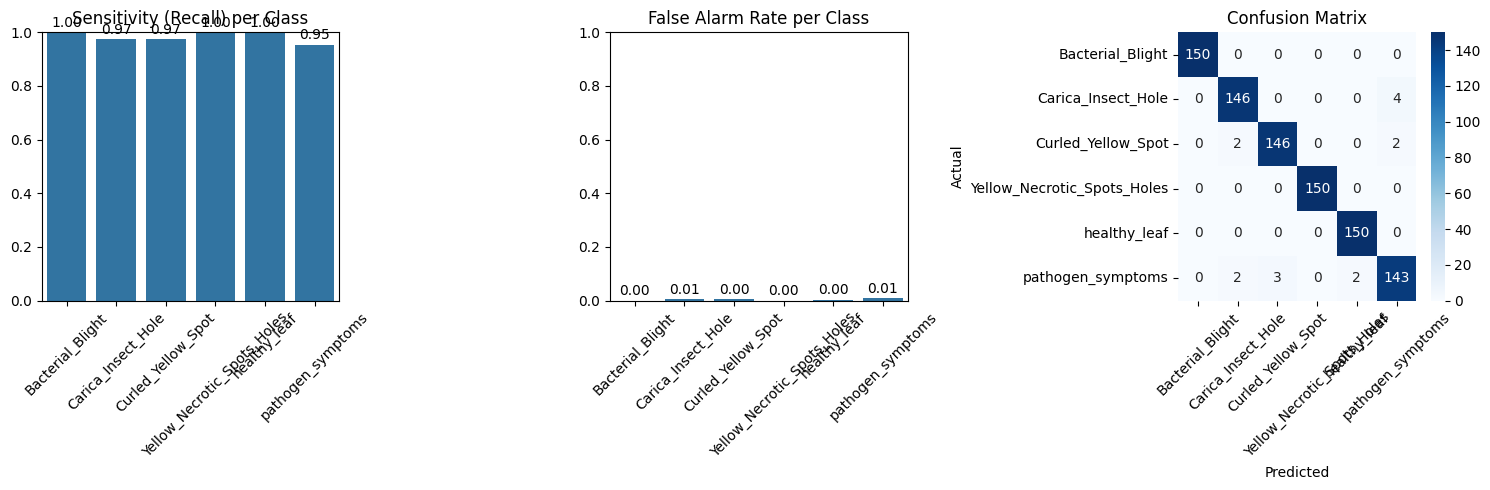


Class-wise Performance Metrics:
Class          Sensitivity    False Alarm Rate    
--------------------------------------------------
Bacterial_Blight1.0000         0.0000              
Carica_Insect_Hole0.9733         0.0053              
Curled_Yellow_Spot0.9733         0.0040              
Yellow_Necrotic_Spots_Holes1.0000         0.0000              
healthy_leaf   1.0000         0.0027              
pathogen_symptoms0.9533         0.0080              

Macro-average Sensitivity: 0.9833
Macro-average False Alarm Rate: 0.0033


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

# 1. Get predictions and true labels
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# 2. Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Calculate metrics for each class
sensitivity = []
false_alarm_rate = []
precision = []

for i in range(len(class_names)):
    # Sensitivity (Recall)
    sensitivity.append(recall_score(y_true, y_pred_classes, labels=[i], average=None)[0])
    
    # False Alarm Rate = FP / (FP + TN)
    fp = np.sum(cm[:, i]) - cm[i, i]
    tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    false_alarm_rate.append(fp / (fp + tn))


# 4. Create visualization
plt.figure(figsize=(15, 5))

# Sensitivity plot
plt.subplot(1, 3, 1)
sns.barplot(x=class_names, y=sensitivity)
plt.title('Sensitivity (Recall) per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(sensitivity):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# False Alarm Rate plot
plt.subplot(1, 3, 2)
sns.barplot(x=class_names, y=false_alarm_rate)
plt.title('False Alarm Rate per Class')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(false_alarm_rate):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')

# Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 5. Print metrics table
print("\nClass-wise Performance Metrics:")
print(f"{'Class':<15}{'Sensitivity':<15}{'False Alarm Rate':<20}")
print("-"*50)
for i in range(len(class_names)):
    print(f"{class_names[i]:<15}{sensitivity[i]:<15.4f}{false_alarm_rate[i]:<20.4f}")


# 6. Calculate macro averages
macro_sensitivity = np.mean(sensitivity)
macro_far = np.mean(false_alarm_rate)
print(f"\nMacro-average Sensitivity: {macro_sensitivity:.4f}")
print(f"Macro-average False Alarm Rate: {macro_far:.4f}")